In [2]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import os
import pdb
import json
from os.path import join as path_join
import cv2
from skimage import measure

In [11]:
# load data
def load_data(path):
    tasks = pd.Series()
    for file_path in os.listdir(path):
        task_file = path_join(path, file_path)
        with open(task_file, 'r') as f:
            task = json.load(f)
        tasks[file_path[:-5]] = task
    return tasks

train_tasks = load_data('../ARC-master/data/training/')

/Users/a18220706/.conda/envs/kaggle-arc/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


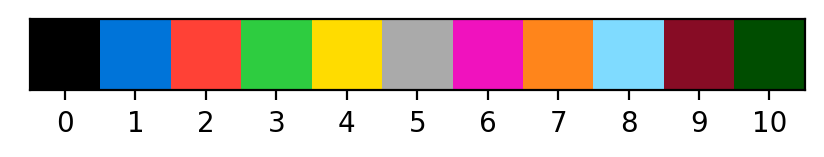

In [25]:
# standardize plotting colors
cmap = colors.ListedColormap(['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
                             '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25', '#004d00'])
BACKGROUND_COLOR = 10
norm = colors.Normalize(vmin = 0, vmax = 10)
# 0:black, 1:blue, 2:red, 3:greed, 4:yellow,
# 5:gray, 6:magenta, 7:orange, 8:sky, 9:brown
# 10:darkgeen
plt.figure(figsize=(5, 2), dpi=200)
plt.imshow([list(range(11))], cmap=cmap, norm=norm)
plt.xticks(list(range(11)))
plt.yticks([])
plt.show()
        

In [36]:
from enum import Enum

class ObjectDetectionMethod(Enum):
    BY_COLOR = 0
    BY_ISOLATION = 1
    BY_COLOR_AND_ISOLATION = 2

class DetectedObject:
    def __init__(self, img, inx):
        # self.pos = pos
        self.inx = inx # the original index of the identified objects (io)
        self.img = img
        self.height = img.shape[0] # height of io
        self.width = img.shape[1] # width of io
        # count of non-background pixels
        self.pixel_count = img[img != BACKGROUND_COLOR].shape[0]
        # overall grid size
        self.size = img.size
        nc, c = np.unique(img, return_counts = True)
        # number of unique colors
        self.unique_colors = nc
        # the dominating color
        self.main_color = nc[np.argmax(c)]
        
        
class ARCSolver:
    def __init__(self, task_num):
        self.task_num = task_num
        # initialize objects-related things
        self.identified_objects = []
        
    def reset(self):
        self.identified_objects = []
        
    
    def plot_one(self, task, ax, i, train_or_test, input_or_output):
        input_matrix = task[train_or_test][i][input_or_output]
        ax.imshow(input_matrix, cmap=cmap, norm=norm)
        ax.grid(True,which='both',color='lightgrey', linewidth=0.5)    
        ax.set_yticks([x-0.5 for x in range(1+len(input_matrix))])
        ax.set_xticks([x-0.5 for x in range(1+len(input_matrix[0]))])     
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title(train_or_test + ' '+input_or_output)
        
    
    def plot_task(self):
        """
        Plots the first train and test pairs of a specified task,
        using same color scheme as the ARC app
        """    
        task = train_tasks[self.task_num]
        name = train_tasks.keys()[self.task_num]
        print('task:', name)
        num_train = len(task['train'])
        fig, axs = plt.subplots(2, num_train, figsize=(3*num_train,3*2))
        for i in range(num_train):     
            self.plot_one(task, axs[0,i],i,'train','input')
            self.plot_one(task, axs[1,i],i,'train','output')        
        plt.tight_layout()
        plt.show()        
            
        num_test = len(task['test'])
        fig, axs = plt.subplots(2, num_test, figsize=(3*num_test,3*2))
        if num_test==1: 
            self.plot_one(task, axs[0],0,'test','input')
            self.plot_one(task, axs[1],0,'test','output')     
        else:
            for i in range(num_test):      
                self.plot_one(task, axs[0,i],i,'test','input')
                self.plot_one(task, axs[1,i],i,'test','output')  
        plt.tight_layout()
        plt.show() 
        
    
    def plot_identified_objects(self, identified_objects, title = 'objects'):
        # do not plot anything in the following situations
        if len(identified_objects) == 0:
            print('No objects were identified.')
            return
        # if len(identified_objects) > 10:
        #     print('Way too many objects (>10). Not gonna plot them.')
        #     return
        
        fig, axs = plt.subplots(1, len(identified_objects) + 1, figsize = (8,2))
        for i in range(len(identified_objects) + 1):
            if i == 0:
                axs[0].text(0.5, 0.5, title, horizontalalignment = 'center', verticalalignment = 'center', fontsize = 15)
                axs[0].get_xaxis().set_visible(False)
                axs[0].get_yaxis().set_visible(False)
                axs[0].axis('off')
            else:
                obj = identified_objects[i-1]
                axs[i].imshow(obj.img, cmap = cmap, norm = norm)
                axs[i].axis('off')
                axs[i].set_title('object{}'.format(i))
        plt.tight_layout()
        plt.show()
    
    
    def get_background(self, image):
        # if image contains 0 
        if 0 in image:
          background = 0
        # else use the most frequent pixel color
        else: 
          unique_colors, counts = np.unique(image, return_counts=True)
          background = unique_colors[np.argmax(counts)]
        return background
    
    
    def check_pairs(self, inx_pairs, this_pair, return_inx = False):
        # check if this_pair is in inx_pairs
        match = []
        for pair in inx_pairs:
          if pair[0] == this_pair[0] and pair[1] == this_pair[1]:
            match.append(True)
          else:
            match.append(False)
        if return_inx:
          return any(match), np.where(match)
        else:
          return any(match)
    
    
    def check_neighbors(self, all_pairs, this_pair, objectness, this_object):
        # all_pairs: an array of index pairs for all nonzero/colored pixels
        # this_pair: the index pair whose neighbors will be checked
        # objectness: an array with the shape of original image, storage for how much objectness has been identified
        # this_object: the current object we are looking at
        row_inx = this_pair[0]
        col_inx = this_pair[1]
        objectness[row_inx, col_inx] = this_object
        # find if any neighboring pixels contain color
        if self.check_pairs(all_pairs, [row_inx-1, col_inx-1]): # up-left
          objectness[row_inx-1, col_inx-1] = this_object
        if self.check_pairs(all_pairs, [row_inx-1, col_inx]): # up
          objectness[row_inx-1, col_inx] = this_object 
        if self.check_pairs(all_pairs, [row_inx-1, col_inx+1]): # up-right
          objectness[row_inx-1, col_inx+1] = this_object
        if self.check_pairs(all_pairs, [row_inx, col_inx-1]): # left
          objectness[row_inx, col_inx-1] = this_object
        if self.check_pairs(all_pairs, [row_inx, col_inx+1]): # right
          objectness[row_inx, col_inx+1] = this_object
        if self.check_pairs(all_pairs, [row_inx+1, col_inx-1]): # down-left
          objectness[row_inx+1, col_inx-1] = this_object
        if self.check_pairs(all_pairs, [row_inx+1, col_inx]): # down
          objectness[row_inx+1, col_inx] = this_object
        if self.check_pairs(all_pairs, [row_inx+1, col_inx+1]): # down-right
          objectness[row_inx+1, col_inx+1] = this_object
        return objectness
    
    
    def identify_object_by_color(self, true_image, background = 0):
        # identify object by the color only 
        unique_colors = np.unique(true_image)
        for i, color in enumerate(unique_colors):
          image = np.copy(true_image) # make a copy from original first
          if color == background: 
            continue
          image[image != color] = BACKGROUND_COLOR
          inx = np.where(image == color)
          img = image[np.min(inx[0]):np.max(inx[0])+1, np.min(inx[1]):np.max(inx[1])+1]
          obj = DetectedObject(img, len(self.identified_objects))
          # append the object attributes
          self.identified_objects.append(obj)
    
    
    def identify_object_by_isolation(self, image, background = 0):
        # identify all objects by physical isolation on the given image
        all_pairs = np.array(np.where(image != background)).T
        objectness = np.zeros(image.shape)
        this_object = 1
        while len(all_pairs) >= 1:
          init_pair = all_pairs[0] # start with the first pair
          objectness = self.check_neighbors(all_pairs, init_pair, objectness, this_object)
          # get a list of index pairs whose neghbors haven't been checked
          unchecked_pairs = np.array(np.where(objectness == this_object)).T
          checked_pairs = np.zeros((0,2)) 
          # check all the index pairs in the expanding unchecked_pairs untill all have been checked
          while len(unchecked_pairs) != 0:
            this_pair = unchecked_pairs[0]
            objectness = self.check_neighbors(all_pairs, this_pair, objectness, this_object)
            # append the checked_pairs
            checked_pairs = np.vstack((checked_pairs, this_pair))
            # get all index pairs for the currently identified object
            current_object_pairs = np.array(np.where(objectness == this_object)).T
            # delete the checked pairs from current object pairs
            checked_inx = []
            for pair in checked_pairs:
              _, inx = self.check_pairs(current_object_pairs, pair, return_inx = True)
              checked_inx.append(inx[0][0])
            unchecked_pairs = np.delete(current_object_pairs, checked_inx, axis = 0)
    
          # store this object to identified_objects
          current_object_pairs = np.array(np.where(objectness == this_object)).T
          cop = current_object_pairs.T
          img = image[np.min(cop[0]):np.max(cop[0])+1, np.min(cop[1]):np.max(cop[1])+1]
          img[img == background] = BACKGROUND_COLOR
          # delete the current object pairs from all_pairs 
          cop_inx = []
          for pair in current_object_pairs:
            _, this_cop_inx = self.check_pairs(all_pairs, pair, return_inx = True)
            cop_inx.append(this_cop_inx[0][0])
          all_pairs = np.delete(all_pairs, cop_inx, axis = 0)
          # append the object attributes
          obj = DetectedObject(img, len(self.identified_objects))
          self.identified_objects.append(obj)          
          # start identifying a new object
          this_object += 1
        return objectness
    
    
    def identify_object_by_color_isolation(self, true_image, background = 0):
        # identify objects first by color then by physical isolation
        unique_colors = np.unique(true_image)
        for i, color in enumerate(unique_colors):
          image = np.copy(true_image) # make a copy from the original first
          if color == background:
            continue
          # identify objects by isolation in this color only 
          image[image != color] = BACKGROUND_COLOR
          self.identify_object_by_isolation(image, background = BACKGROUND_COLOR)
    
    
    def identify_object(self, image, method):
        # a wrapper of different methods
        # in the future method can be a parameter to be learned
        # 1 = by_color, 2 = by_isolation, 3 = by_color_isolation
        background = self.get_background(image)
        if method == ObjectDetectionMethod.BY_COLOR:
          self.identify_object_by_color(image, background)
        elif method == ObjectDetectionMethod.BY_ISOLATION:
          self.identify_object_by_isolation(image, background)
        elif method == ObjectDetectionMethod.BY_COLOR_AND_ISOLATION:
          self.identify_object_by_color_isolation(image, background)
        else:
            raise RuntimeError('Wrong ObjectDetectionMethod')


## Let's have a look at the identified objects

task: 94f9d214


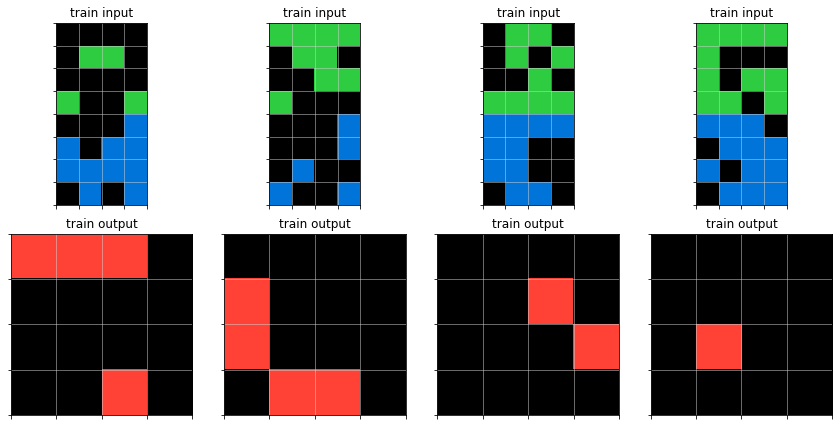

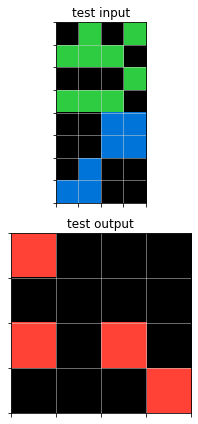

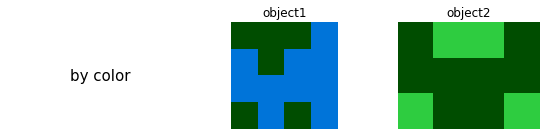

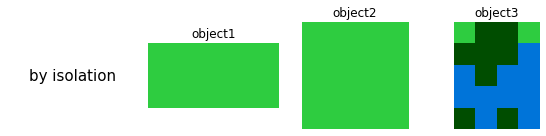

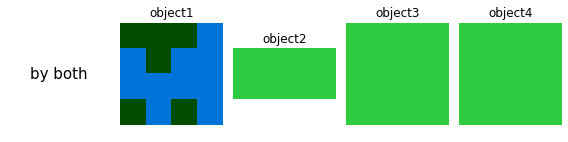

In [37]:
# randomly select 20 task numbers
TASK_NUM = np.random.randint(1,400, size = 20)
TASK_NUM = [7]
for task_num in TASK_NUM:
    arc = ARCSolver(task_num)
    arc.plot_task()
    # select an image for object identification
    # WE USE TRAIN INPUT
    image = np.array(train_tasks[task_num]['train'][0]['input'])

    # identify objects only by color
    arc.reset()
    arc.identify_object(image, ObjectDetectionMethod.BY_COLOR)
    arc.plot_identified_objects(arc.identified_objects, title = 'by color')

    # identify objects only by isolation
    arc.reset()
    arc.identify_object(image, ObjectDetectionMethod.BY_ISOLATION)
    arc.plot_identified_objects(arc.identified_objects, title = 'by isolation')

    # identify objects by color and isolation
    arc.reset()
    arc.identify_object(image, ObjectDetectionMethod.BY_COLOR_AND_ISOLATION)
    arc.plot_identified_objects(arc.identified_objects, title = 'by both')